## Segment-Geospatial: validation tests

Here we study automatic mask generation by `segment-geospatial` on a $60\:\rm{km}^2$ patch of Kitale as a means of assessing its efficiency. Three different types of images are considered
* HSV-EVI images generated using Google Earth Engine (GEE)
* Enhanced RGB image from Copernicus Hub
* High-resolution tile map from Google Earth

Furthermore, the HSV-EVI images are also studied for three different sets of `segment-geospatial` model parameters. The segmentation results are then validated against ground truth polygons that have been manually digitized such the the 'Intersection-over-Union' (IoU) parameter can be calculated between intersecting predefined and generated polygons.

In [1]:
import glob
from typing import List
import numpy as np
import pandas as pd 
import geopandas as gpd
import shapely 
from shapely.geometry import box, Polygon
from shapely.validation import make_valid 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns
import ipywidgets as widgets
from fnmatch import fnmatch
from ipywidgets import interact, interactive, fixed, interact_manual 
from IPython.display import display 

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [2]:
gdf_predefined = gpd.read_file(
    'ground_truths/predefined_polygons.gpkg'
)

# Get list of .gpkg files
gdf_generated_list = glob.glob('validation/**/*.gpkg', recursive=True)

In [14]:
gdf_generated_list

['validation/param2/patch_1_delineation.gpkg',
 'validation/param3/patch_1_delineation.gpkg',
 'validation/from_copernicushub/patch_1_delineation.gpkg',
 'validation/param1/patch_1_delineation.gpkg',
 'validation/tilemap/patch_1_tilemap_delineation.gpkg']

## Filters, spatial joins and combine

The functions perform the following tasks
* `modify_polygons()`: apart from adding geomtric information (like centroids and areas), this function also filters the generated polygon data to remove very large and small polygons as well as ones that are very elongated
* `polygon_overlaps()`: searches for overlaps between predefined and generated polygons using spatial joins and calculates IoU between them, ranking them in descending order

In [4]:
def modify_polygons(
        gdf: gpd.GeoDataFrame,
        type: str, 
        min_polygon_area: float=0.5,
        max_polygon_area: float=500.0,
        elongation_thresh: float=100.0
) -> gpd.GeoDataFrame:
    '''
    This function modifies the predefined and generated polygon gdf, by first
    attaching relevant geometric quantities (centroid and areas) to each polygon.
    Additionally, if the gdf is that of the generated polygons, it filters the
    data to remove very small and large polygons along with elongated shapes.

    Args: (i) gdf - the geopandas dataframe
          (ii) type - specifies the type of dataframe, either 'Predefined' or 'Generated'
          (iii) min_polygon_area - the minimum area of polygons required in gdf_generated; defaults to 0.5 acres
          (iv) max_polygon_area - the maximum area of polygons required in gdf_generated; defaults to 500 acres
          (v) elongation_thresh - threshold for elongation parameter; defaults to 150
    '''
    gdf = gdf.to_crs('EPSG:4326')
    # Calculate relevant geometry quantities
    gdf['centroid'] = gdf.geometry.centroid 
    geom_pseudo_mercator = gdf.geometry.to_crs('EPSG:3587')
    gdf['area (sq. meters)'] = geom_pseudo_mercator.area 
    gdf['area (acres)'] = geom_pseudo_mercator.area * 0.000247 

    if type == 'Predefined':
        return gdf 
    
    elif type == 'Generated':
        '''
        Even after filtering, there will be polygons which are elongated in nature (rivers, streets etc.).
        From common experience, crop fields generally have quite regular shapes. One metric that can be used
        is an elongation ration calculated as perimeter^2 / area. As a reference, such a ratio for a square is
        16. We can set a custom cut-off to further filter out polygons which are very elongated and, hence, not
        representative of fields.
        '''
        elongation = (geom_pseudo_mercator.length**2) / gdf['area (sq. meters)']
        gdf['elongation'] = elongation 

        gdf_filtered = gdf[
            (gdf['area (acres)'] >= min_polygon_area) &
            (gdf['area (acres)'] <= max_polygon_area) &
            (gdf['elongation'] <= elongation_thresh)
        ]

        return gdf_filtered.reset_index(drop=True)
    
    else:
        raise ValueError('Invalid argument for type')
    
def polygon_overlaps(gdf1: gpd.GeoDataFrame, gdf2: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    '''
    This function calculates the overlapping regions between the predefined polygons and
    the ones generated using SamGeo.

    Args: (i) gdf1 - a geopandas dataframe containing the predefined polygons
          (ii) gdf2 - a geopandas dataframe containing the generated polygons

    Returns: a geopandas dataframe containing the overlapping regions sorted by IoU

    The returned geopandas dataframe contains `left_index` and `right_index` indicating
    which polygons in the two original dataframes were overlapped. It also contains an
    extra geometry column (geom_right) for the purposes of IoU calculation.
    '''

    def IoU(poly1: shapely.Polygon, poly2: shapely.Polygon) -> float:
        ''' 
        This is a simple function that calculates the `intersection-over-area` metric for
        determining the extent of overlap between predefined and generated polygons. The
        function is defined to be applied to geopandas dataframe rows using the apply() method.

        Args: (i) poly1 - the left polygon geometry 
              (ii) poly2 - the right polygon geometry
        
        Returns: the IoU value
        '''
        intersection = poly1.intersection(poly2).area 
        union = poly1.union(poly2).area 
        iou = intersection / union 

        return iou

    # Checking if the two dataframes have similarly sized bounding boxes 
    # Rounding up their lon/lat to three decimal places
    gdf1_bounds = np.round(gdf1.total_bounds, decimals=3)
    gdf2_bounds = np.round(gdf2.total_bounds, decimals=3)

    if (gdf1_bounds != gdf2_bounds).any(): 
        print('Fixing bounding boxes.')

        xmin, ymin, xmax, ymax = gdf2_bounds 

        gdf1 = gdf1.cx[xmin:xmax, ymin:ymax] # coordinate-based slicing

    '''
    To get a sense of how many of the generated mask polygons intersect with the predefined ones,
    we perform a `spatial join` with an `intersects` predicate. This will return a dataframe containing
    information on which mask polygons intersect with which predefined polygons.
    '''

    gdf_joined = gpd.sjoin(
        left_df=gdf1,
        right_df=gdf2,
        predicate='intersects',
        how='inner'
    )

    gdf_joined['index_right'] = gdf_joined['index_right'].astype('Int32') # the right_df index may get converted to float
    gdf_joined = (
        gdf_joined
        .reset_index()
        .rename(columns={'index': 'index_left'})
    )

    # Attach the generated polygon geometry as a `geom_right` colums for further calculations
    geom_right = gdf2.loc[gdf_joined['index_right']].geometry.reset_index(drop=True)

    gdf_joined.insert(6, 'geom_right', geom_right)
    gdf_joined.drop(columns=['elongation'], inplace=True)

    ''' 
    Predefined geometries generated manually using GIS software may have so-called `invalid geometries'.
    These can checked for and corrected using shapely methods.
    '''
    geom_check = shapely.is_valid(gdf_joined.geometry)
    invalid_geom_idx = geom_check[~geom_check].index

    for idx in invalid_geom_idx:
        gdf_joined.loc[idx, 'geometry'] = make_valid(gdf_joined.loc[idx, 'geometry'])
    
    gdf_joined['IoU'] = gdf_joined.apply(
        lambda row: IoU(row['geometry'], row['geom_right']),
        axis=1
    )

    '''
    There will be instances where a predefined polygon has intersections with multiple
    mask polygons. We group the data such that we keep only intersections with highest
    IoU and arrange it in descending order of IoU
    '''

    idx = (
        gdf_joined
        .groupby('index_left')['IoU']
        .idxmax()
    )

    gdf_joined = (
        gdf_joined
        .loc[idx]
        .sort_values(by='IoU', ascending=False)
        .reset_index(drop=True)
    )

    return gdf_joined

def gdf_combined(gdf1: gpd.GeoDataFrame, gdf_paths: List[str]) -> gpd.GeoDataFrame:
    ''' 
    This function iterates through all the different generated polygon files (usually
    indicating different parameters), applying filters and calculating overlaps with
    the predefined ones.

    Args: (i) gdf1 - predefined polygon dataframe
          (ii) gdf_paths - file paths to generated polygon files

    Returns: a concatenated dataframe containing the overlap dataframes of each generated
             polygon file in the list. 
    '''
    gdf1 = gdf1.to_crs('EPSG:4326')
    gdf_generated_list = [] # empty list to append generated polygon dataframe

    for path in gdf_paths:
        label = path.split('/')[1]
        gdf_generated = gpd.read_file(path)

        # The column `label` is used to identify the data based on a particular characteristic
        # Here, it can refer to which parameter was used.
        gdf_generated['label'] = pd.Series([label for _ in range(len(gdf_generated))])
        
        gdf_generated_filtered = modify_polygons(
            gdf_generated, 'Generated'
        )
        
        gdf_generated_overlap = polygon_overlaps(
            gdf1, gdf_generated_filtered
        )
        '''
        gdf_generated_list.append(gdf_generated_overlap)
        '''
        gdf_generated_list.append(gdf_generated_overlap)

    gdf_combined = pd.concat(gdf_generated_list, ignore_index=True)

    return gdf_combined

In [5]:
gdf_predefined = modify_polygons(gdf_predefined, 'Predefined')
#gdf_generated = modify_polygons(gdf_generated, 'Generated')

In [6]:
gdf_combined = gdf_combined(gdf_predefined, gdf_generated_list)

gdf_combined.head()

Fixing bounding boxes.
Fixing bounding boxes.
Fixing bounding boxes.
Fixing bounding boxes.


,index_left,geometry,centroid_left,area (sq. meters)_left,area (acres)_left,index_right,geom_right,value,label,centroid_right,area (sq. meters)_right,area (acres)_right,IoU
0,758,"POLYGON ((34.93602 1.0851, 34.94287 1.08512, 3...",POINT (34.93931 1.0828),6.360107e+05,157.094634,997,"POLYGON ((34.93629 1.08514, 34.93629 1.0851, 3...",255.0,param2,POINT (34.93931 1.08284),599262.481439,148.017833,0.938804
1,2,"POLYGON ((34.88719 1.14655, 34.88826 1.15022, ...",POINT (34.88879 1.14633),3.559531e+05,87.920427,139,"POLYGON ((34.88841 1.15015, 34.88841 1.15012, ...",255.0,param2,POINT (34.88877 1.14632),342885.095719,84.692619,0.932035
2,467,"POLYGON ((34.94657 1.11342, 34.94594 1.10863, ...",POINT (34.9482 1.11033),4.154835e+05,102.624426,648,"POLYGON ((34.9467 1.11334, 34.9467 1.11331, 34...",255.0,param2,POINT (34.94815 1.11039),385365.811190,95.185355,0.927405
3,848,"POLYGON ((34.91292 1.09124, 34.90823 1.09104, ...",POINT (34.91108 1.08547),1.038154e+06,256.423987,1004,"POLYGON ((34.91256 1.0912, 34.91256 1.09117, 3...",255.0,param2,POINT (34.91109 1.08558),960228.550596,237.176452,0.924940
4,566,"POLYGON ((34.94519 1.10185, 34.94736 1.10161, ...",POINT (34.94615 1.10083),8.173572e+04,20.188724,747,"POLYGON ((34.94522 1.10174, 34.94522 1.1017, 3...",255.0,param2,POINT (34.94612 1.10081),76963.853219,19.010072,0.924073


## Results

The numbers of intersections for HSV-EVI images across different parameters are relatively consistent. As one expects, polygons generated from the tilemap feature the highest number of intersections, while the enhanced RGB image from Copernicus Hub performing better than HS-EVI.

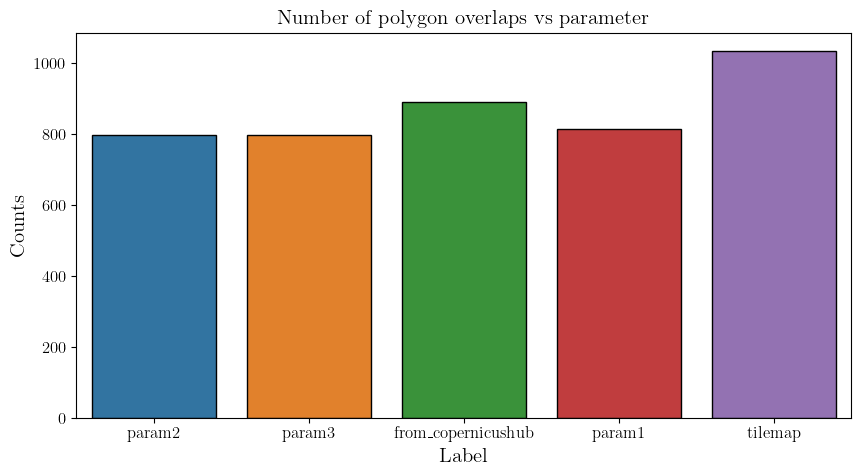

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(gdf_combined, x='label', hue='label', edgecolor='k')

plt.xlabel('Label', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Number of polygon overlaps vs parameter', fontsize=15)

plt.show()

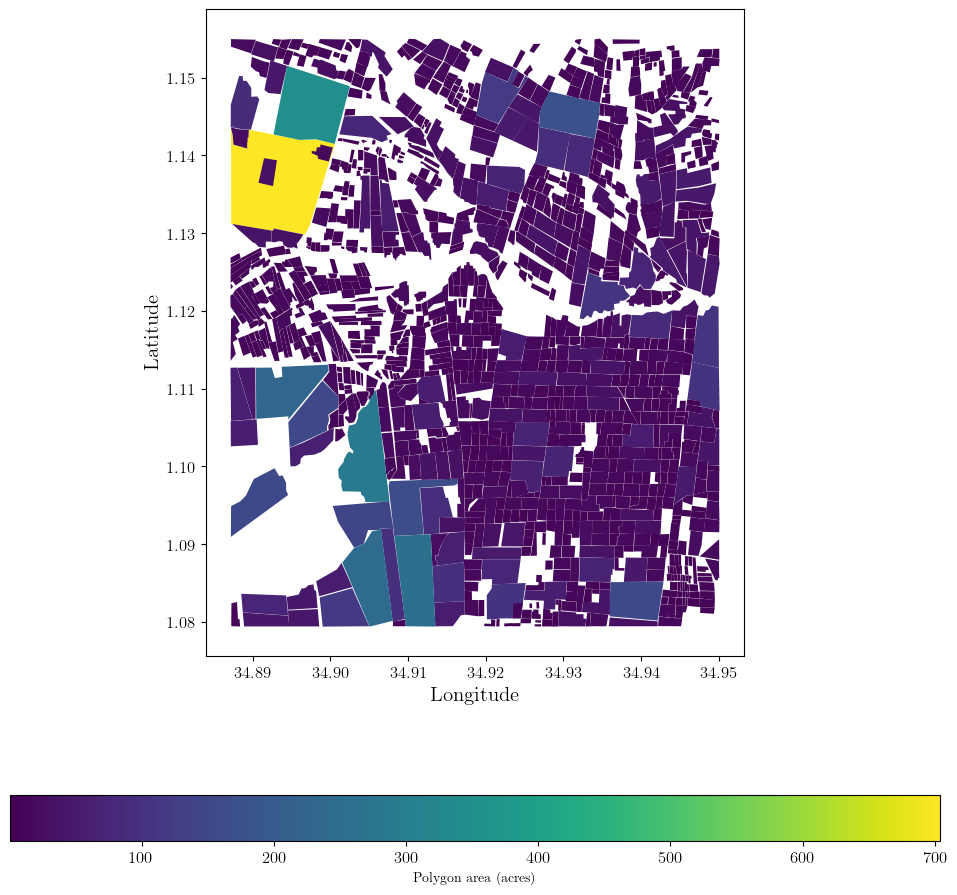

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_predefined.plot(
    ax=ax,
    column='area (acres)',
    cmap='viridis',
    legend=True,
    legend_kwds={"label": "Polygon area (acres)", "orientation": "horizontal"}
)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
plt.show()

In [13]:
def plot_map(label: str) -> None:
    ''' 
    Function for plotting generated polygons based on label for interactive visualization.
    '''
    for file in gdf_generated_list:
        if fnmatch(file, '*/'+label+'/*'):

            data = gpd.read_file(file)
            data = modify_polygons(data, 'Generated')

            fig, ax = plt.subplots(figsize=(12, 12))

            data.plot(
                ax=ax,
                column='area (acres)',
                cmap='viridis',
                legend=True,
                legend_kwds={"label": "Polygon area (acres)", "orientation": "horizontal"}
            )
            ax.set_xlabel('Longitude', fontsize=15)
            ax.set_ylabel('Latitude', fontsize=15)
            plt.show()

There does not seem to be significant differences between the generated polygons for different parameters that have been generated using S2 images. As a result, subsequent comparisons will be made between param1 and tilemap with ground truth data. As can be seen from the interactive plots, the HSV-EVI image does not perform as well as expected. These may be as a result of resolution issues inherent in the GEE generated images. However, the enhanced RGB image downloaded from Copernicus Hub fared much better.

In [14]:
label_dropdown = widgets.Dropdown(options=['param1', 'param2', 'param3', 'tilemap', 'from_copernicushub'])

ui = widgets.HBox([label_dropdown])
output = widgets.interactive_output(plot_map, {'label': label_dropdown})

display(ui, output)

Output()

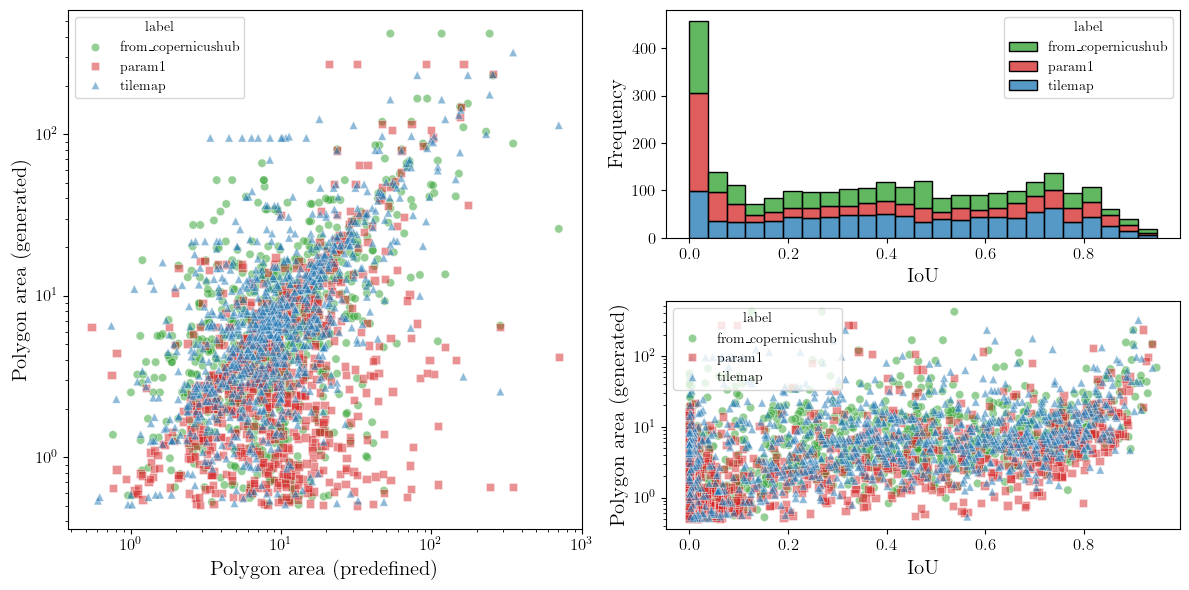

In [12]:
def plot_stats(gdf_combined: gpd.GeoDataFrame) -> None:

    data = gdf_combined[
        (gdf_combined['label'] == 'param1') |
        (gdf_combined['label'] == 'tilemap') |
        (gdf_combined['label'] == 'from_copernicushub')
    ]

    fig = plt.figure(figsize=(12, 6))

    palette = {
        'param1': 'tab:red',
        'tilemap': 'tab:blue',
        'from_copernicushub': 'tab:green'
    }

    gs = gridspec.GridSpec(2, 2, figure=fig)
    ax1 = plt.subplot(gs[:, 0])
    sns.scatterplot(data, x='area (acres)_left', y='area (acres)_right', hue='label', palette=palette, style='label', markers=['o', 's', '^'], alpha=0.5, ax=ax1)
    ax1.set_xlabel('Polygon area (predefined)', fontsize=15)
    ax1.set_ylabel('Polygon area (generated)', fontsize=15)
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    ax2 = plt.subplot(gs[0, 1])
    sns.histplot(data, x='IoU', hue='label', bins=25, multiple='stack', palette=palette, ax=ax2)
    ax2.set_xlabel('IoU', fontsize=15)
    ax2.set_ylabel('Frequency', fontsize=15)

    ax3 = plt.subplot(gs[1, 1])
    sns.scatterplot(data, x='IoU', y='area (acres)_right', hue='label', palette=palette, style='label', markers=['o', 's', '^'], alpha=0.5, ax=ax3)
    ax3.set_xlabel('IoU', fontsize=15)
    ax3.set_ylabel('Polygon area (generated)', fontsize=15)
    ax3.set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_stats(gdf_combined)